In [46]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math
import copy

In [47]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './final_out'

In [48]:
train_settings = {
    "combined_1": {"epochs": 4, "lr": 0.005, "loss_type": ["distribution", "follow_leader"], 
                                            "factor": [20, [0, 2., 4., 6., 8.]], "alpha": 1.},
}

## Dataloader

In [49]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [50]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [51]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [52]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [53]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

In [54]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [55]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train

In [59]:
def train(model, task_num, optimizer_F, criterion, prev_model, factor, alpha = 1., epoches = 4, lr = 0.005, loss_type = ["Baseline"]):
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    distribution_factor = 20
    
    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            model.train()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            diff_loss = 0
            if ("distribution" in loss_type):
                random_data = torch.rand(256, 1, 28, 28).to(device)
                random_data = (random_data - 0.5) / 0.5
                random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
                fake_output = model(random_data)
                diff_loss = distribution_factor * criterion(fake_output, random_target)

            reg_loss = 0
            if (task_num!= 0):
                prev_outputs = None
                if ("follow_leader" in loss_type):
                    for k, prev_mod in enumerate(prev_model):
                        with torch.no_grad():
                            past_output = prev_mod(images)
                        diff = torch.abs(past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2])
                        diff = diff.unsqueeze(0)
                        if (prev_outputs == None):
                            prev_outputs = diff
                        else:
                            prev_outputs = torch.cat((prev_outputs, diff), dim=0)

                    mean_diff = torch.mean(prev_outputs, dim = (1, 2))
                    reg_loss = torch.sum(2 * mean_diff)
            
            classifiaction_loss = criterion(outputs[:,:valid_out_dim], labels)
            loss = classifiaction_loss + reg_loss + diff_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()
            batch_num += 1

        avg_acc = 0
        log_message = []
        log_message.append(f"Epoch: {e}, ")
        for task in range(task_num + 1):
            acc = cal_acc(model, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            log_message.append(f"Task {task} acc: {acc * 100:.4f}")

        logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
        if(task_num != 0):
            logging.info(f'loss:{loss.item()}, c_loss: {classifiaction_loss: .4f}, reg_loss:{reg_loss:.4f}')
    
    return task_accuracies

In [60]:
def setup_logging(file_name):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(file_name),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    print(f"Training on {task_name}")
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    optimizer_F = torch.optim.Adam(model.parameters(), 0.005)
    criterion = nn.CrossEntropyLoss()

    settings = train_settings[task_name]
    epochs, lr, loss_type, factor, alpha = settings['epochs'], settings['lr'], settings['loss_type'], settings['factor'], settings['alpha']

    file_name = f"{output_dir}/{task_name}_epochs={epochs}_alpha={alpha}_factor={factor}"

    log_file_name = file_name + '.log'
    img_file_name = file_name + '.png'
    if True:
    # if os.path.exists(log_file_name) == False:
        setup_logging(log_file_name)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            task_accuracies = train(model, task, optimizer_F, criterion, prev_model, factor = factor, alpha = alpha, 
                                           epoches = epochs, lr = lr, loss_type = loss_type)
            all_accuracies.append(task_accuracies)
            prev_model.append(copy.deepcopy(model))

        plot_task_acc_history(all_accuracies, img_file_name, epochs)

2024-06-02 10:29:38,600 - INFO - ##########Task 0##########
2024-06-02 10:29:38,601 - INFO - Epoch 0


Training on combined_1


2024-06-02 10:29:45,663 - INFO - Epoch: 0, , Task 0 acc: 83.0357, Task avg acc:83.0357
2024-06-02 10:29:45,664 - INFO - Epoch 1
2024-06-02 10:29:52,088 - INFO - Epoch: 1, , Task 0 acc: 96.7873, Task avg acc:96.7873
2024-06-02 10:29:52,090 - INFO - Epoch 2
2024-06-02 10:29:58,462 - INFO - Epoch: 2, , Task 0 acc: 98.3099, Task avg acc:98.3099
2024-06-02 10:29:58,463 - INFO - Epoch 3
2024-06-02 10:30:05,001 - INFO - Epoch: 3, , Task 0 acc: 97.3932, Task avg acc:97.3932
2024-06-02 10:30:05,005 - INFO - ##########Task 1##########
2024-06-02 10:30:05,006 - INFO - Epoch 0
2024-06-02 10:30:13,687 - INFO - Epoch: 0, , Task 0 acc: 77.7264, Task 1 acc: 70.3042, Task avg acc:74.0153
2024-06-02 10:30:13,688 - INFO - loss:47.21038055419922, c_loss:  0.9047, reg_loss:0.1544
2024-06-02 10:30:13,689 - INFO - Epoch 1
2024-06-02 10:30:22,301 - INFO - Epoch: 1, , Task 0 acc: 77.4872, Task 1 acc: 64.7856, Task avg acc:71.1364
2024-06-02 10:30:22,302 - INFO - loss:47.14297103881836, c_loss:  0.8530, reg_los

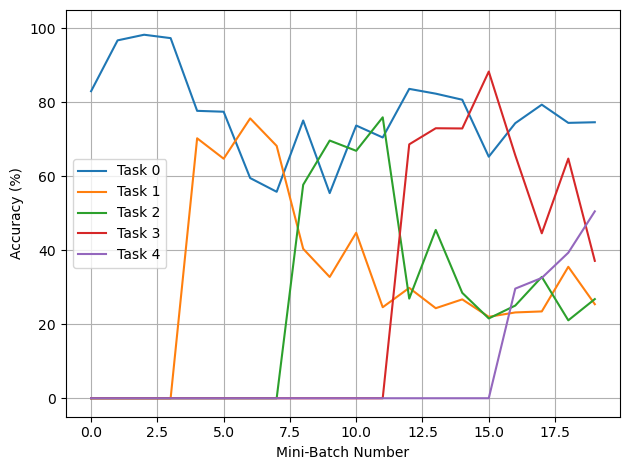

In [61]:
for key in train_settings.keys():
    train_split_task(key)